### Hypothesis

Whether a data point should be updated in SVM can be casted as a nearest neighbor problem.

### Expected Result

If the hypothesis is true, we should observe that there exists a constant C, such at all data 
points with distance smaller than C should be updated, while all data points with distance
larger than C should not be updated.

That is, the plot of (distance vs. is_update) should be a stage

### TODO

As we will see, when RCV1 converges, only 40% data points need update. This means that we can be at most 2x faster on RCV1. This is because the final training accuracy on RCV1 is high, we might want to understand the level of final accuracy of our target workload
   - This should be able to be fixed by a hybrid index

In [1]:
%matplotlib inline
"""
First, Prepare RCV1 Data
"""
from sklearn.datasets import fetch_rcv1
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [2]:
rcv1 = fetch_rcv1()

In [3]:
CCAT = 33
ECAT = 59
GCAT = 70
MCAT = 102

In [4]:
CCAT_IDXS = np.where((rcv1.target[:,CCAT]==1).todense())[0]
ECAT_IDXS = np.where((rcv1.target[:,ECAT]==1).todense())[0]
GCAT_IDXS = np.where((rcv1.target[:,GCAT]==1).todense())[0]
MCAT_IDXS = np.where((rcv1.target[:,MCAT]==1).todense())[0]

In [6]:
# Do the same positive/negative separation as https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html
POS_IDXS  = np.unique(np.union1d(CCAT_IDXS, ECAT_IDXS))
NEG_IDXS  = np.unique(np.union1d(GCAT_IDXS, MCAT_IDXS))
POS_AND_NEG = np.intersect1d(POS_IDXS, NEG_IDXS)
POS_IDXS  = np.delete(POS_IDXS, POS_AND_NEG)
NEG_IDXS  = np.delete(NEG_IDXS, POS_AND_NEG)

In [7]:
print "# POS EXAMPLES", POS_IDXS.shape
print "# NEG EXAMPLES", NEG_IDXS.shape

# POS EXAMPLES (409667,)
# NEG EXAMPLES (379903,)


In [8]:
labels = np.zeros((rcv1.data.shape[0], 1))
labels[POS_IDXS] = 1
labels[NEG_IDXS] = -1

In [9]:
Corpus = sparse.csr_matrix(sparse.hstack((rcv1.data, labels)))

In [10]:
def ShuffleSparse(matrix):
    index = np.arange(np.shape(matrix)[0])
    np.random.shuffle(index)
    return matrix[index, :]
Train = ShuffleSparse(Corpus[0:20242, :])

In [11]:
"""
Second, Train a Vanilla SVM with Standard SGD 
"""
def SGD_1Epoch(data, model, lr = 0.01):
    N_UPDATES = 0
    N_TOTAL   = 0
    for index in range(0, data.shape[0]):

        N_TOTAL = N_TOTAL + 1
        
        feat = data[index, :-1]
        label = data[index, -1]
        
        dot_prod = feat.dot(model)[0, 0]
        
        if 1 - dot_prod * label > 0:
            grad = - label * feat
            model = model - lr * grad.transpose()
            N_UPDATES = N_UPDATES + 1
    return (model, 1.0*N_UPDATES, 1.0*N_TOTAL)
                           
def SVM_Loss(data, model):
    loss = 0.0
    for index in range(0, data.shape[0]):
        feat = data[index, :-1]
        label = data[index, -1]
        dot_prod = feat.dot(model)[0, 0]
        loss = loss + max(0, 1 - dot_prod * label)
    return loss / data.shape[0]

In [34]:
model = sparse.csr_matrix(np.zeros((np.shape(Train)[1]-1, 1))) # init random model
NEPOCH = 10
for iepoch in range(0, 10):
    print SVM_Loss(Train, model)
    (model, nupdate, ntotal) = SGD_1Epoch(Train, model)
    print "--TRAIN %Updates=", nupdate/ntotal, 

1.0
--TRAIN %Updates= 0.964183381089 0.5818222558
--TRAIN %Updates= 0.762424661595 0.456488287603
--TRAIN %Updates= 0.647465665448 0.399127286089
--TRAIN %Updates= 0.577759114712 0.365957428764
--TRAIN %Updates= 0.525442149985 0.344853629335
--TRAIN %Updates= 0.490860586899 0.329597328109
--TRAIN %Updates= 0.460379409149 0.318363741844
--TRAIN %Updates= 0.436073510523 0.309650465491
--TRAIN %Updates= 0.420017784804 0.302341716523
--TRAIN %Updates= 0.406333366268


In [12]:
"""
Third, validate that normalizing the input to unit norm does not have impact on the quality
"""

'\nThird, validate that normalizing the input to unit norm does not have impact on the quality\n'

In [13]:
from sklearn.preprocessing import normalize
Corpus_Normalized = sparse.csr_matrix(sparse.hstack((normalize(rcv1.data, axis=1, norm='l2'), labels)))

In [14]:
Train_Normalized = ShuffleSparse(Corpus_Normalized[0:20242, :])

In [15]:
model = sparse.csr_matrix(np.zeros((np.shape(Train)[1]-1, 1))) # init random model
NEPOCH = 10
for iepoch in range(0, 10):
    print SVM_Loss(Train_Normalized, model)
    (model, nupdate, ntotal) = SGD_1Epoch(Train_Normalized, model)
    print "--TRAIN %Updates=", nupdate/ntotal, 

1.0
--TRAIN %Updates= 0.96220729177 0.583140448668
--TRAIN %Updates= 0.764746566545 0.456758284883
--TRAIN %Updates= 0.650429799427 0.398720427414
--TRAIN %Updates= 0.576820472285 0.365821187071
--TRAIN %Updates= 0.524750518723 0.34483980026
--TRAIN %Updates= 0.491354609228 0.329558705978
--TRAIN %Updates= 0.461021638178 0.318295067875
--TRAIN %Updates= 0.435777097125 0.309619406744
--TRAIN %Updates= 0.419770773639 0.30233732441
--TRAIN %Updates= 0.406333366268


In [48]:
"""
Forth, validate that whether update happens is correlated to nearest neighbor to the model
"""
distances = []
isupdates = []
model_norm = sparse.linalg.norm(model)
for index in range(0, Train_Normalized.shape[0]):
    feat = Train_Normalized[index, :-1]
    label = Train_Normalized[index, -1]    
    dot_prod = feat.dot(model)[0, 0]

    if 1 - dot_prod * label > 0: 
        is_update = 1 
    else: 
        is_update = 0
        
    if label > 0: # Negative Examples should be indexed separately, in a very simialr way
        distance = sparse.linalg.norm((- model)  - feat.transpose())
        distances.append(distance)
        isupdates.append(is_update)
    if label < 0:
        distance = sparse.linalg.norm((model)  - feat.transpose())
        distances.append(distance)
        isupdates.append(is_update)
        

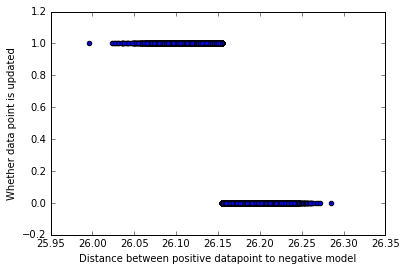

In [49]:
plt.scatter(distances, isupdates)
plt.xlabel('Distance between positive datapoint to negative model')
plt.ylabel('Whether data point is updated')
plt.show()

In [51]:
import math
C = math.sqrt(model_norm**2 + 3)

In [53]:
print C

26.1548037953


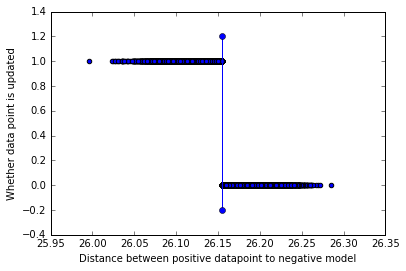

In [60]:
plt.scatter(distances, isupdates)
plt.xlabel('Distance between positive datapoint to negative model')
plt.ylabel('Whether data point is updated')
plt.plot([C, C], [-0.2, 1.2], '-o')
plt.show()